In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os

import yaml
import json
import os

import argparse
import glob
import torch as th
from environment_vect import Reward_Network
from logger import MetricLogger
from dqn_agent import Agent
from config_type import Config
from common.utils.utils import estimate_solution_score
from common.models.network import Network


In [3]:
experiment_type = 'reward-network-iii-exp-v2'
moves_df = pd.read_csv(os.path.join('../../analysis/data/experiment/processed/moves.csv'))

networks_file = '../../data/24_02_04/solution__valid_networks.json'

# Load the networks
with open(networks_file) as f:
    networks_exp = json.load(f)
    
config_file = '../../algorithm/params/seed_0.yml'
with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = Config(**config)


In [4]:
moves_df['session_trial_id'] = moves_df['session_id'].astype(str) + '_' + moves_df['trial_id'].astype(str)

session_trial_id = moves_df['session_trial_id'].unique()
session_trial_idx = {session_trial_id[i]: i for i in range(len(session_trial_id))}

In [5]:
human_moves = th.full((len(session_trial_id), 10), -1, dtype=th.int64)
network_ids = []

for _, row in moves_df.iterrows():
    idx = session_trial_idx[row['session_trial_id']]
    human_moves[idx, row['move_idx']] = row['target_num']
    if row['move_idx'] == 0:
        network_ids.append(row['network_id'])

In [6]:
networks_keyed = {network['network_id']: network for network in networks_exp}
networks_reorganized = [networks_keyed[network_id] for network_id in network_ids]

In [8]:
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")

env = Reward_Network(networks_reorganized, network_batch=None, config=config, device=DEVICE)

AI_agent = Agent(
    observation_shape=env.observation_shape,
    config=config,
    action_dim=env.action_space_idx.shape,
    save_dir=None,
    device=DEVICE,
)
path = os.path.join('../..',config.save_dir, f"{config.name}_{config.seed}.pt")
AI_agent.load_model(path)

# solve all networks at once in one go ("1 episode")
ai_moves = AI_agent.solve_loop(
    episode=0,
    n_rounds=config.n_rounds,
    train_mode=False,
    exp_mode=True,
    env=env,
    logger=None,
    exec_actions=human_moves,
)

Number of networks loaded: 1013
environment_vect reward_norm_map tensor([ 0.0000, -1.0000, -0.7778, -0.3333,  0.1111,  1.0000], device='cuda:0')
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])
torch.Size([19568])


In [9]:
moves_df['ai_target_num'] = None

for idx, row in moves_df.iterrows():
    session_idx = session_trial_idx[row['session_trial_id']]
    move_idx = row['move_idx']
    moves_df.at[idx, 'ai_target_num'] = ai_moves[session_idx, move_idx]

In [10]:
moves_df['human_machine_match'] = moves_df['ai_target_num'] == moves_df['target_num']

In [ ]:
moves_df.to_csv(os.path.join('../../analysis/data/experiment/processed/moves_w_alignment.csv'), index=False)

<Axes: xlabel='generation', ylabel='human_machine_match'>

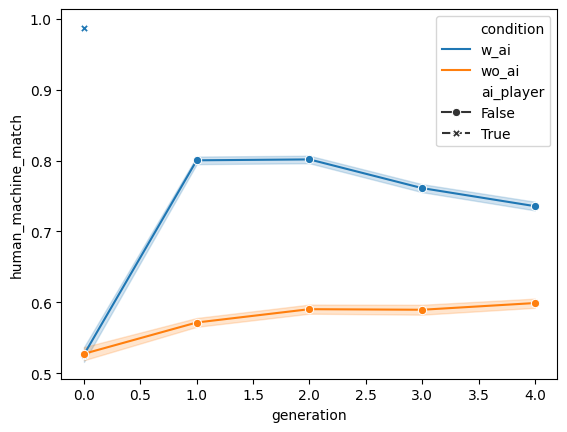

In [27]:
import seaborn as sns

df = moves_df[moves_df['trial_type'] == 'demonstration']

sns.lineplot(data=moves_df, x='generation', hue='condition', style='ai_player', y='human_machine_match', markers=True)


In [13]:
df.columns

Index(['session_id', 'session_name', 'replication_idx', 'condition',
       'generation', 'within_generation_idx', 'started_at', 'time_spend',
       'expired', 'replaced', 'ai_player', 'simulated_subject', 'advisor',
       'player_score', 'move_idx', 'source_num', 'target_num', 'reward',
       'level', 'correct_repeat', 'myopic', 'optimal', 'large_loss_taken',
       'trial_id', 'trial_type', 'network_id', 'solution_total_score',
       'session_trial_id', 'ai_target_num', 'human_machine_match'],
      dtype='object')